In [1]:
import pandas as pd
import numpy as np
import os
import random
import torch
import pickle
import utilities
import preprocess
import similarities
import parameters
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations, product

from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

In [2]:
result_file_name = 'embedding_tuning_ohsumed-2.p'

In [3]:
data = 'ohsumed'

In [4]:
embedding_methods = ['all-MiniLM-L6-v2', 
                     'all-MiniLM-L12-v2', 
                     'all-mpnet-base-v1', 
                     'all-mpnet-base-v2', 
                     'all-roberta-large-v1', 
                     'all-distilroberta-v1']

In [5]:
random_state = parameters.random_state
np.random.seed(random_state)
data_paths = parameters.data_paths

In [6]:
df = utilities.read_data(data_paths[data])
X = df['text'].apply(preprocess.preprocess_text)
y = df.drop(['text'], axis=1)

In [7]:
total_samples = dict(y.sum())

In [8]:
def calculate_between_class_similarities(col1, col2, X, y):
    
    sims = []
    
    for idx1 in y[y[col1]==1].index:
        for idx2 in y[y[col2]==1].index:
            sims.append(similarities.vector_similarity(X.loc[idx1], X.loc[idx2]))
    
    return sum(sims)/len(sims)     

In [9]:
def calculate_similarity_matrix(X, y, sim_method='cosine'):
    
    import similarities
    
    sim_df = pd.DataFrame(index=y.columns, columns=y.columns)
    
    for col in y.columns:
        sim_df.loc[col, col] = similarities.calculate_similarity_within_classes(X.loc[y[y[col]==1].index], sim_calculation_type='average')
    
    for col1, col2 in list(combinations(y.columns, 2)):
        sim_df.loc[col1, col2] = similarities.calculate_similarity_between_classes(X.loc[y[y[col1]==1].index], X.loc[y[y[col2]==1].index], sim_calculation_type='average')
    
    return sim_df

In [10]:
def calculate_matrix_score(sim_df):
    scores = []
    for col in sim_df.columns:
        scores.append((sim_df.loc[col, col] - sim_df.loc[col].drop(col).max())/sim_df.loc[col, col])
    return scores

In [11]:
def vectorize_data(text, model):
    
    # model = SentenceTransformer(model_name)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    vectors = model.encode(text, convert_to_tensor=False, device=device)
    
    return vectors

In [12]:
def create_train_data(X_num, X, y, samples):
    
    train_set = []

    for col in y.columns:

        idxs = y[y[col]==1].index
        
        # idxs = find_best_samples(X_num.loc[idxs], samples[col])
        # tmp_set = X.loc[idxs]
        
        tmp_set = X.loc[idxs].sample(samples[col])
        
        for pair in combinations(tmp_set, 2):
            train_set.append(InputExample(texts=list(pair), label=1.0))

    for col1, col2 in combinations(y.columns,2):
        
        sample_num = samples[(col1, col2)]
        idxs1 = y[(y[col1]==1)&(y[col2]==0)].index
        idxs2 = y[(y[col2]==1)&(y[col1]==0)].index
        tmp_samples = random.sample(list(product(idxs1, idxs2)), sample_num)
        
        tmp_set1 = X.loc[[i[0] for i in tmp_samples]]
        tmp_set2 = X.loc[[i[1] for i in tmp_samples]]
        
        for pair in zip(tmp_set1, tmp_set2):
            train_set.append(InputExample(texts=list(pair), label=0.0))

    print(len(train_set))
    
    return train_set

In [13]:
def create_initial_samples(y, within_col, between_col):    
    samples = {}

    for col in y.columns:
        samples[col] = within_col

    for col1, col2 in combinations(y.columns, 2):
        samples[(col1, col2)] = between_col
        
    return samples

In [14]:
def update_sample_sizes(simd_df, samples):
    
    for col1, col2 in combinations(simd_df.columns, 2):
        if simd_df.loc[col1, col2] > 0.2:
            samples[(col1, col2)] = int((1/(1-simd_df.loc[col1, col2]))*samples[(col1, col2)])
        
        if samples[(col1, col2)] > total_samples[col1]*total_samples[col2]:
            samples[(col1, col2)] = int(total_samples[col1]*total_samples[col2])
            
    for col in simd_df.columns:
        if simd_df.loc[col, col] < 0.5:
            samples[col] = int((1/simd_df.loc[col, col])*samples[col])
            
        if samples[col] > total_samples[col]:
            samples[col] = total_samples[col]
            
    return samples

In [15]:
if not os.path.exists(result_file_name):
    tuning_results = {}
    with open(result_file_name, 'wb') as f:
        pickle.dump(tuning_results, f)

In [16]:
with open(result_file_name, 'rb') as f:
    tuning_results = pickle.load(f)

In [17]:
iterate = [i for i in embedding_methods if i not in tuning_results.keys()]

In [18]:
with open('embedding_results_ohsumed.p', 'rb') as f:
    initial_results = pickle.load(f)

In [20]:
embedding_method = 'all-mpnet-base-v1'
X_num = utilities.vectorize_data(X, embedding_method)

samples = False

for epoch_num in [2]:
    
    if not samples:
        samples = create_initial_samples(y, 40, 60)
        print('initial samples are created!')
     
    train_set = create_train_data(X_num, X, y, samples)
    
    
    sim_df_before = initial_results[embedding_method]
    
    model = SentenceTransformer(embedding_method, device='cuda') 

    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
    train_loss = losses.CosineSimilarityLoss(model)

    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=epoch_num, warmup_steps=50)

    X_num_tuned = vectorize_data(X, model)
    X_num_tuned = pd.Series([np.squeeze(i) for i in X_num_tuned])
    sim_df_after = calculate_similarity_matrix(X_num_tuned, y)
    
    tuning_results[embedding_method] = (sim_df_before, sim_df_after)
    
    samples = update_sample_sizes(sim_df_after, samples)
    
    with open(result_file_name, 'wb') as f:
        pickle.dump(tuning_results, f)

initial samples are created!
18000


C:\Users\IsmailKaraman\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3000 [00:00<?, ?it/s]

In [21]:
stop

NameError: name 'stop' is not defined

In [ ]:
tuning_results['all-MiniLM-L6-v2']

In [ ]:
with open(result_file_name, 'rb') as f:
    tuning_results = pickle.load(f)

In [ ]:
aa.keys()

In [22]:
def scoring(sim_df):    
    scores = calculate_matrix_score(sim_df)[:-1]
    print(f'max: {max(scores):.2f}, min: {min(scores):.2f}, avg: {sum(scores)/len(scores):.2f}')

    l_sum = 100*np.diag(sim_df).sum()/12 - (sim_df.sum().sum()-np.diag(sim_df).sum())/66
    print(f'{l_sum:.2f}') 

all-MiniLM-L6-v2
before
max: 0.59, min: 0.14, avg: 0.31
26.19
after
max: 0.86, min: -0.21, avg: 0.36
45.93


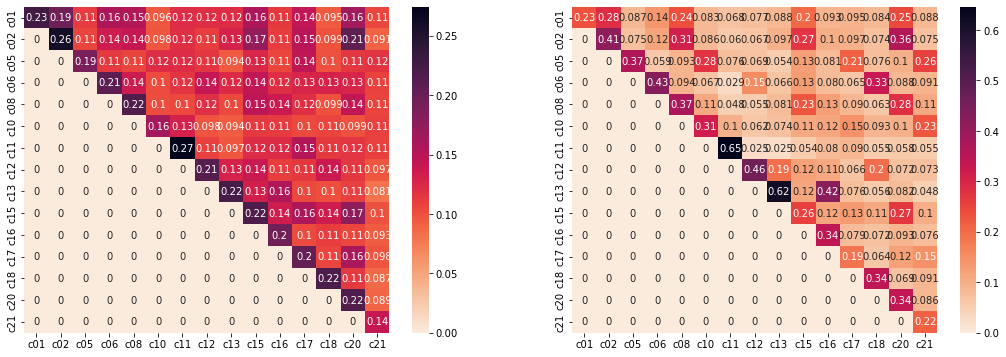

**********************************************************************
all-mpnet-base-v1
before
max: 0.59, min: 0.20, avg: 0.36
25.79
after
max: 0.91, min: -0.22, avg: 0.46
39.61


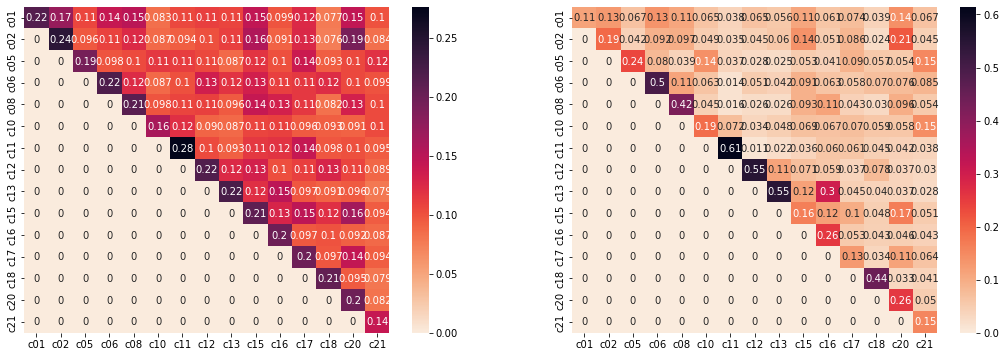

**********************************************************************


In [23]:
for k,v in tuning_results.items():
    print(k)
    print('before')
    scoring(v[0])
    print('after')
    scoring(v[1])
    
    # fig, axes = plt.subplots(1, 2, figsize=(16,5), squeeze=False)
    fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
    ax1, ax2 = axes
    sns.heatmap(v[0].fillna(0), annot=True,
                        xticklabels=v[0].columns,
                        yticklabels=v[0].columns, ax=ax1, cmap="rocket_r")
    sns.heatmap(v[1].fillna(0), annot=True,
                        xticklabels=v[1].columns,
                        yticklabels=v[1].columns, ax=ax2, cmap="rocket_r")

    plt.show()

    print('*'*70)